In [36]:
import os
import numpy as np
import pandas as pd
import json

from dask import bag, diagnostics 

import hvplot.pandas

In [37]:
def create_image_df(folder_path):
    # List all files in the directory
    file_names = os.listdir(folder_path)

    # Filter list for image files
    image_files = [file for file in file_names if file.endswith(('.png', '.jpg', '.jpeg'))]

    # Create a DataFrame
    df = pd.DataFrame(image_files, columns=['image_file'])

    # Prepend the folder path to the image file names
    df['image_file'] = df['image_file'].apply(lambda x: os.path.join(folder_path, x))

    return df

# Usage
folder_path = "data_raw/img"
df = create_image_df(folder_path)
df.head()

,image_file
0,data_raw/img/69351.png
1,data_raw/img/17843.png
2,data_raw/img/27980.png
3,data_raw/img/24537.png
4,data_raw/img/53967.png


In [38]:
TRAIN_JSONL_PATH = "data_raw/train.jsonl"
EVAL_JSONL_PATH = "data_raw/dev.jsonl"
TEST_JSONL_PATH = "data_raw/test.jsonl"

In [39]:
def read_jsonl(path):
    # Open the JSONL file
    with open(path, 'r') as file:
        data_list = []
        
        # Read each line in the file
        for line in file:
            # Parse the JSON data from each line
            data = json.loads(line)
            
            # Append the JSON data to the list
            data_list.append(data)

    # Create a Pandas DataFrame from the list of JSON objects
    df = pd.DataFrame(data_list)
    return df

train = read_jsonl(TRAIN_JSONL_PATH)
eval = read_jsonl(EVAL_JSONL_PATH)
test = read_jsonl(TEST_JSONL_PATH)

#### Basic Stats

In [5]:
train.shape

(8500, 4)

In [6]:
eval.shape

(500, 4)

In [7]:
test.shape

(1000, 3)

### Image Resolutions

In [8]:
from tensorflow.keras.preprocessing import image
import cv2

2023-05-22 16:42:40.971779: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [40]:
train["dataset"] = "train"
eval["dataset"] = "eval"
test["dataset"] = "test"

df = pd.concat([train, eval, test], ignore_index=True)
df.head()

,id,img,label,text,dataset
0,42953,img/42953.png,0.0,its their character not their color that matters,train
1,23058,img/23058.png,0.0,don't be afraid to love again everyone is not ...,train
2,13894,img/13894.png,0.0,putting bows on your pet,train
3,37408,img/37408.png,0.0,i love everything and everybody! except for sq...,train
4,82403,img/82403.png,0.0,"everybody loves chocolate chip cookies, even h...",train


In [42]:
df["img"] = "data_raw/" + df["img"].astype(str)

In [17]:
df

,id,img,label,text,dataset
0,42953,data_raw/img/42953.png,0.0,its their character not their color that matters,train
1,23058,data_raw/img/23058.png,0.0,don't be afraid to love again everyone is not ...,train
2,13894,data_raw/img/13894.png,0.0,putting bows on your pet,train
3,37408,data_raw/img/37408.png,0.0,i love everything and everybody! except for sq...,train
4,82403,data_raw/img/82403.png,0.0,"everybody loves chocolate chip cookies, even h...",train
...,...,...,...,...,...
9995,3869,data_raw/img/03869.png,NaN,a mother's love for the child is a divine thing,test
9996,23817,data_raw/img/23817.png,NaN,sea monkeys,test
9997,56280,data_raw/img/56280.png,NaN,little miss muffet sat on her tuffet,test
9998,29384,data_raw/img/29384.png,NaN,they're in a row,test


In [25]:
def get_dims(file):
    img = cv2.imread(file)
    h,w = img.shape[:2]
    return h,w

# parallelize
filelist = df["img"].tolist()

dimsbag = bag.from_sequence(filelist).map(get_dims)
with diagnostics.ProgressBar():
    dims = dimsbag.compute()
    
dim_df = pd.DataFrame(dims, columns=['height', 'width'])
dim_df["dataset"] = df["dataset"]

[########################################] | 100% Completed | 10.17 s


In [32]:
import hvplot.pandas

# Corresponding colors for each dataframe
colors = ['red', 'green', 'blue']
datasets = ["train", "eval", "test"]

dfs = [dim_df[dim_df.dataset == dataset] for dataset in datasets]

# Create initial plot with the first DataFrame
final_plot = dfs[0].hvplot.scatter(
    x='height', 
    y='width', 
    size='count',
    color=colors[0],  # assign color for first df
    xlim=(0,1200), 
    ylim=(0,1200),
    scaling_factor=0.1,
    label=datasets[0]  # add label for legend
)

# Iterate over the rest of the dataframes
for df, color, dataset in zip(dfs[1:], colors[1:], datasets[1:]):
    scatter = df.hvplot.scatter(
        x='height', 
        y='width', 
        size='count',
        color=color,  # assign color for current df
        xlim=(0,1200), 
        ylim=(0,1200),
        scaling_factor=0.1,
        label=dataset  # add label for legend
    )
    # Overlay the plots
    final_plot *= scatter

final_plot = final_plot.options(
    xticks=2, 
    yticks=2, 
    height=500, 
    width=600,
    title="Overlay Scatter Plot of Image Resolutions by Dataset",
    show_legend=True  # ensure legend is shown
)

final_plot


:Overlay
   .Scatter.Train :Scatter   [height]   (width)
   .Scatter.Eval  :Scatter   [height]   (width)
   .Scatter.Test  :Scatter   [height]   (width)

### Colormap Analysis

In [41]:
df

,id,img,label,text,dataset
0,42953,img/42953.png,0.0,its their character not their color that matters,train
1,23058,img/23058.png,0.0,don't be afraid to love again everyone is not ...,train
2,13894,img/13894.png,0.0,putting bows on your pet,train
3,37408,img/37408.png,0.0,i love everything and everybody! except for sq...,train
4,82403,img/82403.png,0.0,"everybody loves chocolate chip cookies, even h...",train
...,...,...,...,...,...
9995,3869,img/03869.png,NaN,a mother's love for the child is a divine thing,test
9996,23817,img/23817.png,NaN,sea monkeys,test
9997,56280,img/56280.png,NaN,little miss muffet sat on her tuffet,test
9998,29384,img/29384.png,NaN,they're in a row,test


In [43]:
datasets

['train', 'eval', 'test']

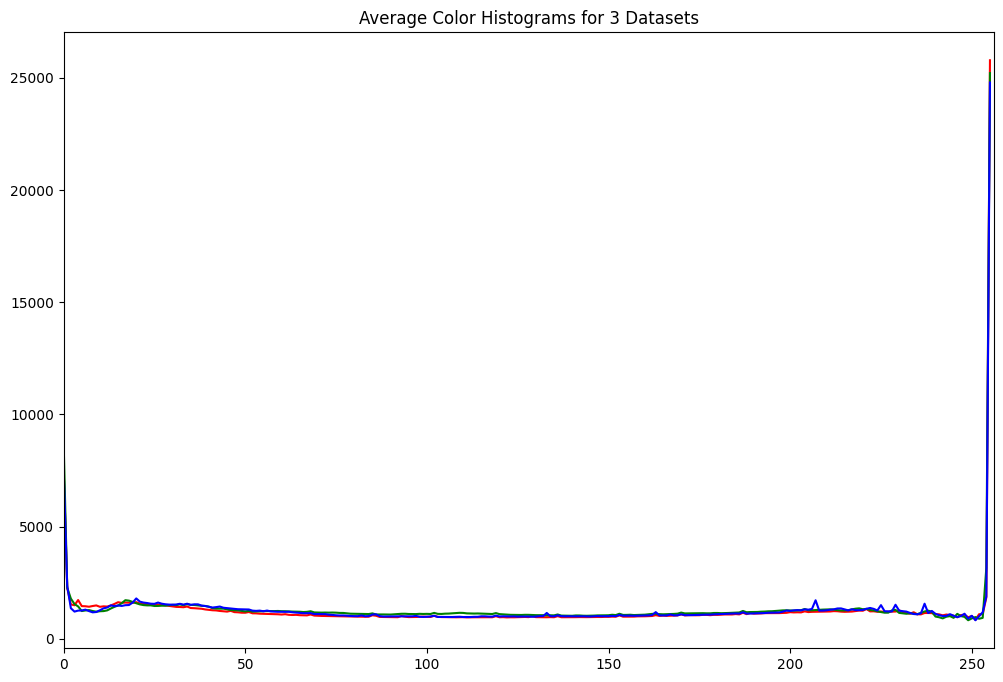

In [47]:
import matplotlib.pyplot as plt

dfs = [df[df.dataset == dataset] for dataset in datasets]


def calculate_color_hist(image_path):
    # Load the image
    img = cv2.imread(image_path)
    # Convert from BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Calculate the histogram
    color = ('r','g','b')
    hist = []
    for i in range(3):  # For each color channel
        histr = cv2.calcHist([img],[i],None,[256],[0,256])
        hist.append(histr)
    return np.array(hist) 

def plot_average_hist(df, color):
    # Calculate color histogram for each image and take the average
    avg_hist = np.mean(df['img'].apply(calculate_color_hist).to_list(), axis=0)
    # Plot the average histogram
    for i,col in enumerate(color):
        plt.plot(avg_hist[i],color = col)
        plt.xlim([0,256])

# Plot average color histograms for each dataset
plt.figure(figsize=(12, 8))
plot_average_hist(dfs[0], 'r')
plot_average_hist(dfs[1], 'g')
plot_average_hist(dfs[2], 'b')

plt.title('Average Color Histograms for 3 Datasets')
plt.show()
